**Mounting Google Drive:** The code mounts Google Drive to access files stored there.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Loading the Dataset and Dependencies**


**Installing Libraries**

It installs necessary libraries like

*   datasets
*   transformers
*   saqeval






In [ ]:
!pip install datasets transformers

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=bec6e463a5bcbcb9572af59dc98c24b04178ce776cb0146cd1a7213f8e4c6f0a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
!pip install datasets --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

**Importing Modules**

imports various Python modules for data handling,
machine learning, and logging.

In [ ]:
import os
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification,
    AutoModelForCausalLM,
)
from seqeval.metrics import classification_report
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import logging
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from huggingface_hub import login
import subprocess
import itertools

**Setting up Logging**

This section configures logging to record information about the code's execution.

In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO, filename='experiment_3_3_a100.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

**Setting CUDA_LAUNCH_BLOCKING**


*   This line is specifically for debugging when using a GPU (Graphics Processing Unit) with CUDA (Compute Unified Device Architecture).
*   CUDA_LAUNCH_BLOCKING: This is the specific environment variable being targeted. It controls how CUDA operations are launched on the GPU.
*   1: This value is being assigned to the environment variable. Setting it to '1' essentially forces CUDA operations to be synchronous


In [ ]:
# Set CUDA_LAUNCH_BLOCKING for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

**Hugging Face Authentication and Device Check**

*   Authenticating with Hugging Face: This is necessary to access and download models from the Hugging Face Model Hub.
*   Checking for GPU Availability: It determines whether a GPU is available for faster model training and inference.



In [ ]:
# Authenticate Hugging Face
hf_token = #add hugging face token
if hf_token:
    try:
        login(hf_token)
        process = subprocess.run(['huggingface-cli', 'login', '--token', hf_token], capture_output=True, text=True)
        if process.returncode == 0:
            logger.info("Authenticated with Hugging Face CLI successfully")
        else:
            logger.error(f"Hugging Face CLI login failed: {process.stderr}")
            raise RuntimeError(f"Hugging Face CLI login failed: {process.stderr}")
    except Exception as e:
        logger.error(f"Failed to authenticate with Hugging Face: {str(e)}")
        raise
else:
    logger.info("No Hugging Face token provided; using open-source model mistralai/Mixtral-8x7B-Instruct-v0.1")

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

**Loading the Dataset**

*   load_dataset : This function is from the datasets library and is designed to load datasets from various sources.
*   surrey-nlp/PLOD-CW-25 : This string specifies the dataset to be loaded. It likely refers to the PLOD-CW-25 dataset hosted on the Hugging Face Hub under the surrey-nlp organization.



In [ ]:
# Step 1: Load the PLOD-CW-25 dataset
logger.info("Loading PLOD-CW-25 dataset")
dataset = load_dataset('surrey-nlp/PLOD-CW-25')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

**Label Mapping**
This section of the code defines how the model will understand and represent  labels in the  dataset


1.  **labels in the  dataset**


*   'O'  stands for "Outside" – meaning the
word is not part of any named entity.
*   'B-AC'  represent the beginning of an "Abbreviation" entity.
*   'B-LF'  represent the beginning of a "Long Form" entity.
*   'I-LF'  represent the continuation of a "Long Form" entity.

2.  **Label-to-ID Mapping**: label2id dictionary maps each label to a unique numerical ID using a dictionary comprehension:

3. **ID-to-Label Mapping** :id2label dictionary performs the reverse mapping, associating each numerical ID with its corresponding label







In [ ]:
# Define label mapping
label_list = ['O', 'B-AC', 'B-LF', 'I-LF']
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

**Data Preprocessing**



*   **Tokenization and Chunking**: The input text is tokenized. Long sequences are split into smaller chunks to fit the model's input size limitations. This is crucial for handling lengthy medical reports which often exceed the maximum token limit of transformer models.
*  ** Label Alignment**: The original entity labels are carefully aligned with the tokenized input. This ensures that each token, including subwords generated during tokenization, receives the correct label. This alignment is essential for the model to learn the associations between tokens and their corresponding entities
*   **Padding and Masking**: The tokenized sequences are padded to a uniform length, and an attention mask is created to indicate which tokens are actual input and which are padding. Padding ensures that all inputs have the same shape, while the attention mask helps the model focus on relevant tokens during processing.
*   **Output Formatting**: The function returns a dictionary containing the processed input_ids, attention_mask, and aligned labels. This formatted output is then ready to be used for training or evaluating the NER model





In [ ]:
#step 2 : Preprocessing
def preprocess_data(examples, tokenizer, max_length=512):
    tokens = examples['tokens']
    ner_tags = examples['ner_tags']

    tokenized_inputs = {'input_ids': [], 'attention_mask': [], 'labels': []}

    for i in range(len(tokens)):
        seq_length = len(tokens[i])
        logger.info(f"Processing sequence {i} with length {seq_length}")
        if seq_length > max_length - 2:
            num_chunks = (seq_length // (max_length - 2)) + (1 if seq_length % (max_length - 2) else 0)
            logger.warning(f"Sequence {i} exceeds max_length {max_length}. Splitting into {num_chunks} chunks.")

        # Split long sequences
        token_chunks = [tokens[i][j:j+max_length-2] for j in range(0, len(tokens[i]), max_length-2)]
        tag_chunks = [ner_tags[i][j:j+max_length-2] for j in range(0, len(ner_tags[i]), max_length-2)]

        for chunk_idx, (token_chunk, tag_chunk) in enumerate(zip(token_chunks, tag_chunks)):
            if not token_chunk:
                logger.warning(f"Empty chunk detected for sequence {i}, chunk {chunk_idx}. Skipping.")
                continue

            chunk_length = len(token_chunk)
            logger.debug(f"Tokenizing chunk {chunk_idx} with {chunk_length} tokens")
            if chunk_length > max_length - 2:
                logger.error(f"Chunk {chunk_idx} for sequence {i} exceeds max_length: {chunk_length} tokens. Skipping.")
                continue

            try:
                encoding = tokenizer(
                    token_chunk,
                    is_split_into_words=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                    return_offsets_mapping=False
                )
            except Exception as e:
                logger.error(f"Tokenization failed for sequence {i}, chunk {chunk_idx}: {str(e)}")
                continue

            word_ids = encoding.word_ids()
            aligned_labels = [-100] * len(word_ids)
            prev_word_idx = None
            for idx, word_idx in enumerate(word_ids):
                if word_idx is None:
                    continue
                elif word_idx != prev_word_idx:
                    try:
                        aligned_labels[idx] = label2id[tag_chunk[word_idx]]
                    except IndexError:
                        logger.error(f"IndexError: word_idx {word_idx} out of bounds for tag_chunk of length {len(tag_chunk)} in sequence {i}")
                        continue
                prev_word_idx = word_idx

            tokenized_inputs['input_ids'].append(encoding['input_ids'].squeeze().tolist())
            tokenized_inputs['attention_mask'].append(encoding['attention_mask'].squeeze().tolist())
            tokenized_inputs['labels'].append(aligned_labels)

    logger.info(f"Processed {len(tokenized_inputs['input_ids'])} chunks for {len(tokens)} sequences")
    return tokenized_inputs

**Fine-tuning a Model for Token Classification**

*   Initialization: starts by loading the pre-trained tokenizer and model using AutoTokenizer and AutoModelForTokenClassification from the transformers library
*   Data Preparation: tokenize_and_align_labels function is defined to prepare the dataset for the model. This function tokenizes the input text using the loaded tokenizer, aligns the labels with the tokens, and pads the sequences to a uniform length
*   Hyperparameter Tuning:parameter grid is defined with different values for learning rate, batch size, and weight decay, the code iterates through all combinations of these hyperparameters to find the best configuration.
*   Model Training: For each hyperparameter combination, a TrainingArguments,Trainer,trainer.train()  method is called to start the fine-tuning process.






In [ ]:
# Step 3: Fine-tuning Function
def fine_tune_model(model_name, dataset, output_dir, num_train_epochs=3, add_prefix_space=True):
    logger.info(f"Starting fine-tuning for {model_name}")

    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=add_prefix_space)
        model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=4,
            # Ensure all arguments  indented with 4 spaces
            id2label={0: "O", 1: "B-AC", 2: "B-LF", 3: "I-LF"},
            label2id={"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}
        ).to(device)
        logger.info(f"Loaded {model_name} for fine-tuning")
    except Exception as e:
        logger.error(f"Failed to load model or tokenizer for {model_name}: {str(e)}")
        raise

    label2id = {"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(
            examples['tokens'],
            truncation=True,
            is_split_into_words=True,
            padding='max_length',
            max_length=512
        )
        labels = []
        for i, label in enumerate(examples['ner_tags']):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    # Handle  labels
                    if isinstance(label[word_idx], (int, np.integer)):
                        label_id = label[word_idx]
                    else:
                        label_id = label2id[label[word_idx]]
                    label_ids.append(label_id)
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            # Pad labels to match tokenized input length
            input_length = len(tokenized_inputs['input_ids'][i])
            label_ids = label_ids + [-100] * (input_length - len(label_ids))
            labels.append(label_ids[:512])  # Ensure max_length
        tokenized_inputs["labels"] = labels
        logger.info(f"Sample tokenized inputs: {tokenized_inputs['input_ids'][0][:10]}")
        logger.info(f"Sample labels: {labels[0][:10]}")
        return tokenized_inputs

    tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=['tokens', 'ner_tags'])

    param_grid = {
       'learning_rate': [1e-5, 2e-5, 3e-5],
       'per_device_train_batch_size': [8,16],
       'weight_decay': [0.01, 0.1],
    }
    all_combinations = list(itertools.product(*param_grid.values()))

    for lr, batch_size, weight_decay in all_combinations:
        # Create TrainingArguments with the current hyperparameters
        training_args = TrainingArguments(
            output_dir=f"./experiment_lr_{lr}_bs_{batch_size}_wd_{weight_decay}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=lr,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            logging_dir='./logs',
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model="f1"
        )

    def compute_metrics(eval_pred): # This line was incorrectly indented
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        true_labels = [[l for l in label if l != -100] for label in labels]
        pred_labels = [
            [p for (p, l) in zip(pred, label) if l != -100]
            for pred, label in zip(predictions, labels)
        ]
        true_labels = [[model.config.id2label[l] for l in label] for label in true_labels]
        pred_labels = [[model.config.id2label[p] for p in label] for label in pred_labels]
        report = classification_report(true_labels, pred_labels, output_dict=True)
        return {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1": report["weighted avg"]["f1-score"],
            "accuracy": report["weighted avg"]["f1-score"]
        }

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    try:
        trainer.train()
        logger.info(f"Fine-tuning completed for {model_name}")
    except Exception as e:
        logger.error(f"Training failed for {model_name}: {str(e)}")
        raise

    # Save per-epoch metrics to text file
    with open("experiment_3_3_a100.txt", "a") as f:
        f.write(f"Experiment: {model_name} Fine-tuning\n")
        for log in trainer.state.log_history:
            if 'epoch' in log and 'loss' in log:
                epoch = int(log['epoch'])
                loss = log['loss']
                # Find corresponding eval metrics
                eval_f1 = 0.0
                for eval_log in trainer.state.log_history:
                    if 'epoch' in eval_log and eval_log['epoch'] == epoch and 'eval_f1' in eval_log:
                        eval_f1 = eval_log['eval_f1']
                        break
                f.write(f"Epoch: {epoch}, Loss: {loss:.3f}, Accuracy: {eval_f1:.3f}\n")

    metrics = trainer.evaluate()
    logger.info(f"Evaluation results for {model_name}:\n{metrics}")

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    return metrics

**Zero-Shot Prompting Function**

This code defines a function called zero_shot_prompting that performs zero-shot named entity recognition (NER) using a large language model (LLM). This means it tries to identify entities in text without any specific training data for that task.

*   Initialization:Imports necessary libraries,Defines the zero_shot_prompting function, taking the dataset, model name, Hugging Face token, and maximum examples as input
*   Model Loading:The function zero_shot_prompting is defined, taking the dataset, model_name, Hugging Face token, and max_examples as input. It defaults to using the google/gemma-7b-it model and processes a maximum of 50 examples.
*   Label Mapping : The dictionaries (id2label,label2id) define the mapping between numerical IDs and the NER labels
*   Output Parsing Function :This function takes the raw output from the LLM and the expected number of labels and tries to extract a list of string labels. It handles different output formats and applies fallbacks if parsing fails.
*   Prediction Loop :loop iterates through the validation dataset, splits the text into chunks, creates prompts, feeds them to the LLM, parses the output, and stores the predictions and true labels.
*   Metrics Calculation : alculates the 'precision', 'recall', 'f1-score', and 'accuracy' using 'classification_report' from seqeval.metrics.
It writes the results to a file and logs them







In [ ]:
# Step 4: Zero-shot Prompting Function
import ast
import tqdm
import torch
import gc
import logging
import os

def zero_shot_prompting(dataset, model_name='google/gemma-7b-it', token=None, max_examples=50):
    logger.info(f"Starting zero-shot prompting with {model_name}, limiting to {max_examples} examples")

    # Ensure logger
    for handler in logger.handlers:
        handler.flush()

    try:
        logger.info("Loading tokenizer")
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
        # Set padding token
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            logger.info(f"Set tokenizer.pad_token to {tokenizer.pad_token}")

        logger.info("Loading model")
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            token=token
        )
        # move model to GPU
        device = torch.device("cuda:0")
        model = model.to(device)
        logger.info(f"Loaded {model_name} with torch.float16 precision on {device}")

        # Verify model device
        param_device = next(model.parameters()).device
        logger.info(f"Model parameter device: {param_device}")
        if param_device != device:
            logger.error(f"Model parameters not on {device}, found {param_device}")
            raise RuntimeError(f"Model not on {device}")

        # Log VRAM usage
        vram_usage = torch.cuda.memory_allocated(device) / 1024**3
        logger.info(f"VRAM usage after model load: {vram_usage:.2f} GB")
    except Exception as e:
        logger.error(f"Failed to load model or tokenizer for {model_name}: {str(e)}")
        raise

    id2label = {0: "O", 1: "B-AC", 2: "B-LF", 3: "I-LF"}
    label2id = {"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

    def parse_model_output(output, expected_length):
        """Parse model output to extract a flat list of string labels."""
        try:
            output = output.strip()
            logger.info(f"Parsing output: {output}, expected length: {expected_length}")
            if output.startswith('[') and output.endswith(']'):
                parsed = ast.literal_eval(output)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    parsed = [x for x in parsed if x in label2id]
                    logger.info(f"Parsed labels: {parsed}, length: {len(parsed)}")
                    if len(parsed) == expected_length:
                        return parsed
                    elif len(parsed) > expected_length:
                        return parsed[:expected_length]
                    else:
                        return parsed + ['O'] * (expected_length - len(parsed))
            if ',' in output:
                parsed = [x.strip().strip("'\"") for x in output.strip('[]').split(',')]
                parsed = [x for x in parsed if x in label2id]
                logger.info(f"Parsed labels (comma-split): {parsed}, length: {len(parsed)}")
                if len(parsed) == expected_length:
                    return parsed
                elif len(parsed) > expected_length:
                    return parsed[:expected_length]
                else:
                    return parsed + ['O'] * (expected_length - len(parsed))
            logger.warning(f"Invalid output format: {output}")
            return ['O'] * expected_length
        except Exception as e:
            logger.warning(f"Failed to parse output: {output}, error: {str(e)}")
            return ['O'] * expected_length

    predictions = []
    true_labels = []
    max_chunk_size = 20

    # Limit to max_examples
    validation_subset = dataset['validation'].select(range(min(max_examples, len(dataset['validation']))))

    for example_idx, example in enumerate(tqdm.tqdm(validation_subset, desc="Processing examples")):
        tokens = example['tokens']
        true_ner_tags = example['ner_tags']
        true_labels.append(list(true_ner_tags))

        for i in range(0, len(tokens), max_chunk_size):
            chunk_tokens = tokens[i:i + max_chunk_size]
            chunk_length = len(chunk_tokens)
            logger.info(f"Example {example_idx}, chunk {i//max_chunk_size}: {chunk_tokens}, length: {chunk_length}")

            prompt = (
                f"Perform token classification on the following sequence of tokens. "
                f"Assign one of these labels to each token: ['O', 'B-AC', 'B-LF', 'I-LF']. "
                f"'O' is for non-entity tokens (e.g., 'the', '.'), 'B-AC' for the start of an abbreviation (e.g., 'EPI'), "
                f"'B-LF' for the start of a long form (e.g., 'Echo'), and 'I-LF' for continuation of a long form (e.g., 'planar'). "
                f"Return a list of exactly {chunk_length} labels, one for each token, in order, as a Python list, e.g., [\"O\", \"B-AC\", ...]. "
                f"Do not include extra text or explanations, only the list.\n\n"
                f"Tokens: {chunk_tokens}\n\n"
                f"Labels: "
            )

            try:
                inputs = tokenizer(prompt, return_tensors="pt")
                # Explicitly move each tensor to device
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Log input tensor devices
                for k, v in inputs.items():
                    logger.info(f"Input tensor {k} device: {v.device}")

                # Verify all inputs are on the same device
                input_devices = {k: v.device for k, v in inputs.items()}
                if not all(d == device for d in input_devices.values()):
                    logger.error(f"Input tensors not all on {device}: {input_devices}")
                    predictions.append(['O'] * chunk_length)
                    continue

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=100,
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id
                    )

                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                generated_text = generated_text.split("Labels: ")[-1].strip()
                logger.info(f"Raw generated text: {generated_text}")

                pred_labels = parse_model_output(generated_text, chunk_length)
                logger.info(f"Parsed pred_labels: {pred_labels}")

                if len(pred_labels) == chunk_length:
                    predictions.append(pred_labels)
                    logger.info(f"Valid prediction for chunk: {pred_labels}")
                else:
                    predictions.append(['O'] * chunk_length)
                    logger.warning(f"Applied fallback labels for chunk: {chunk_tokens}")

                # Clear memory
                del outputs, inputs
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
                vram_usage = torch.cuda.memory_allocated(device) / 1024**3
                logger.info(f"VRAM usage after chunk: {vram_usage:.2f} GB")
            except Exception as e:
                logger.warning(f"Generation failed for chunk: {chunk_tokens}, error: {str(e)}")
                predictions.append(['O'] * chunk_length)

        # Flush logs after each example
        for handler in logger.handlers:
            handler.flush()

    flat_predictions = [label for pred in predictions for label in pred]
    flat_true_labels = [label for true in true_labels for label in true]

    min_length = min(len(flat_predictions), len(flat_true_labels))
    flat_predictions = flat_predictions[:min_length]
    flat_true_labels = flat_true_labels[:min_length]

    try:
        report = classification_report(
            [flat_true_labels],
            [flat_predictions],
            output_dict=True,
            zero_division=0
        )
        metrics = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1": report["weighted avg"]["f1-score"],
            "accuracy": report["weighted avg"]["f1-score"]
        }
    except Exception as e:
        logger.error(f"Failed to compute classification report: {str(e)}")
        metrics = {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 0.0}

    with open("experiment_3_3_a100.txt", "a") as f:
        f.write(f"Experiment: Zero-shot Prompting\n")
        f.write(f"Epoch: 0, Loss: 0.000, Accuracy: {metrics['f1']:.3f}\n")

    logger.info(f"Zero-shot results: {metrics}")

    # Clean up
    del model, tokenizer
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()

    return metrics

**Few-Shot Prompting Function**

This code defines a function called few_shot_prompting that performs few-shot named entity recognition (NER). This technique uses a large language model (LLM) to identify entities in text by providing it with a small number of examples (called "shots") during inference, instead of extensive fine-tuning

1. **Initialization**:The few_shot_prompting function is defined, taking the dataset, model_name, Hugging Face token, max_examples, and shots as input. It's using the google/gemma-7b-it model, processes a maximum of 50 examples, and uses 3 shots

2. **Model and Tokenizer** :The code loads the causal language model using AutoModelForCausalLM.from_pretrained and tokenizer for the specified 'model_name' using 'AutoTokenizerfrom_pretrained'

3. **Output Parsing** : 'parse_model_output Function' function takes the raw output from the LLM and the expected_length (number of labels) and tries to extract a list of string labels. It handles different output formats and applies fallbacks if parsing fails.

4. **few-shot prompting**:The code handles the core logic of few-shot prompting, including:


*   Selecting few-shot examples.
*   Constructing prompts.
*   Feeding prompts to the LLM.
*   Parsing the output.
* Calculating metrics


In [ ]:
# Step 3.3.5: Few-shot Prompting Function
import ast
import tqdm
import torch
import gc
import logging
import os
import re
from random import sample

def few_shot_prompting(dataset, model_name='google/gemma-7b-it', token=None, max_examples=50, shots=3):
    logger.info(f"Starting few-shot prompting with {model_name}, limiting to {max_examples} examples, using {shots} shots")

    # Ensure logger flushes
    for handler in logger.handlers:
        handler.flush()

    try:
        logger.info("Loading tokenizer")
        tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
        # Set padding token explicitly
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
            logger.info(f"Set tokenizer.pad_token to {tokenizer.pad_token}")

        logger.info("Loading model")
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            token=token
        )
        # Explicitly move model to GPU
        device = torch.device("cuda:0")
        model = model.to(device)
        logger.info(f"Loaded {model_name} with torch.float16 precision on {device}")

        # Verify model device
        param_device = next(model.parameters()).device
        logger.info(f"Model parameter device: {param_device}")
        if param_device != device:
            logger.error(f"Model parameters not on {device}, found {param_device}")
            raise RuntimeError(f"Model not on {device}")

        # Log VRAM usage
        vram_usage = torch.cuda.memory_allocated(device) / 1024**3
        logger.info(f"VRAM usage after model load: {vram_usage:.2f} GB")
    except Exception as e:
        logger.error(f"Failed to load model or tokenizer for {model_name}: {str(e)}")
        raise

    id2label = {0: "O", 1: "B-AC", 2: "B-LF", 3: "I-LF"}
    label2id = {"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

    def parse_model_output(output, expected_length):
        """Parse model output to extract a flat list of string labels."""
        try:
            output = output.strip()
            logger.info(f"Raw output: {output}, expected length: {expected_length}")

            # Clean up Markdown and structured text
            output = re.sub(r'```[\s\S]*?```', lambda m: m.group(0).strip('```').strip(), output)
            output = re.sub(r'\*\*Answer\*\*:?\s*', '', output, flags=re.IGNORECASE)
            output = re.sub(r'\*\*Explanation\*\*:?.*', '', output, flags=re.IGNORECASE | re.DOTALL)
            output = output.strip()
            logger.info(f"Cleaned output after regex: {output}")

            # Map numeric strings to string labels
            num_to_label = {'0': 'O', '1': 'B-AC', '2': 'B-LF', '3': 'I-LF'}

            if output.startswith('[') and output.endswith(']'):
                parsed = ast.literal_eval(output)
                if isinstance(parsed, list):
                    # Convert numeric strings to string labels
                    parsed = [num_to_label.get(x, x) if isinstance(x, str) else x for x in parsed]
                    # Filter valid labels
                    parsed = [x for x in parsed if x in label2id]
                    logger.info(f"Parsed labels: {parsed}, length: {len(parsed)}")
                    logger.info(f"Expected length: {expected_length}, Parsed length: {len(parsed)}")
                    if len(parsed) == expected_length:
                        return parsed
                    elif len(parsed) > expected_length:
                        return parsed[:expected_length]
                    else:
                        return parsed + ['O'] * (expected_length - len(parsed))
            elif ',' in output:
                parsed = [x.strip().strip("'\"") for x in output.strip('[]').split(',')]
                # Convert numeric strings to string labels
                parsed = [num_to_label.get(x, x) for x in parsed]
                # Filter valid labels
                parsed = [x for x in parsed if x in label2id]
                logger.info(f"Parsed labels (comma-split): {parsed}, length: {len(parsed)}")
                logger.info(f"Expected length: {expected_length}, Parsed length: {len(parsed)}")
                if len(parsed) == expected_length:
                    return parsed
                elif len(parsed) > expected_length:
                    return parsed[:expected_length]
                else:
                    return parsed + ['O'] * (expected_length - len(parsed))
            elif output and not (output.startswith('[') and output.endswith(']')) and not ',' in output:
                # Handle plain text or malformed outputs
                parsed = [x.strip() for x in output.split() if x.strip() in label2id]
                parsed = [num_to_label.get(x, x) for x in parsed]
                logger.info(f"Parsed labels (plain text): {parsed}, length: {len(parsed)}")
                logger.info(f"Expected length: {expected_length}, Parsed length: {len(parsed)}")
                if len(parsed) == expected_length:
                    return parsed
                elif len(parsed) > expected_length:
                    return parsed[:expected_length]
                else:
                    return parsed + ['O'] * (expected_length - len(parsed))
            logger.warning(f"Invalid output format: {output}")
            return ['O'] * expected_length
        except Exception as e:
            logger.warning(f"Failed to parse output: {output}, error: {str(e)}")
            return ['O'] * expected_length

    predictions = []
    true_labels = []
    max_chunk_size = 15

    # Select few-shot examples from training set
    train_data = dataset['train']
    # Prefer examples with non-O labels
    diverse_examples = [ex for ex in train_data if any(tag in [1, 2, 3] for tag in ex['ner_tags'])]
    if not diverse_examples:
        logger.warning("No examples with non-O labels found; using random examples")
        diverse_examples = train_data
    few_shot_examples = sample(list(diverse_examples), min(shots, len(diverse_examples)))
    few_shot_prompts = []
    for ex in few_shot_examples:
        tokens = ex['tokens'][:max_chunk_size]
        labels = [id2label[tag] if isinstance(tag, int) else tag for tag in ex['ner_tags']][:max_chunk_size]
        few_shot_prompts.append(f"{tokens} → {labels}")

    # Join few-shot prompts with newlines
    few_shot_text = '\n'.join(few_shot_prompts)
    logger.info(f"Few-shot prompts:\n{few_shot_text}")

    # Limit to max_examples
    validation_subset = dataset['validation'].select(range(min(max_examples, len(dataset['validation']))))

    for example_idx, example in enumerate(tqdm.tqdm(validation_subset, desc="Processing examples")):
        tokens = example['tokens']
        true_ner_tags = example['ner_tags']
        true_labels.append([id2label[tag] if isinstance(tag, int) else tag for tag in true_ner_tags])

        for i in range(0, len(tokens), max_chunk_size):
            chunk_tokens = tokens[i:i + max_chunk_size]
            chunk_length = len(chunk_tokens)
            logger.info(f"Example {example_idx}, chunk {i//max_chunk_size}: {chunk_tokens}, length: {chunk_length}")
            logger.info(f"Expected labels for chunk: {[tag for tag in example['ner_tags'][i:i + max_chunk_size]]}")

            # Construct few-shot prompt
            prompt = (
                f"Perform token classification on the following sequence of tokens. "
                f"Assign one of these labels to each token: ['O', 'B-AC', 'B-LF', 'I-LF']. "
                f"'O' is for non-entity tokens (e.g., 'the', '.'), 'B-AC' for the start of an abbreviation (e.g., 'EPI'), "
                f"'B-LF' for the start of a long form (e.g., 'Echo'), and 'I-LF' for continuation of a long form (e.g., 'planar').\n\n"
                f"Below are example token-label pairs to guide your labeling:\n"
                f"{few_shot_text}\n\n"
                f"Now, classify the following tokens:\n"
                f"Tokens: {chunk_tokens}\n"
                f"Return a list of exactly {chunk_length} string labels in the format [\"O\", \"B-AC\", ...], one for each token, in order, as a Python list. "
                f"Examples: ['EPI', 'Echo', 'planar', '.'] → [\"B-AC\", \"B-LF\", \"I-LF\", \"O\"]; ['The', 'MRI', 'scan'] → [\"O\", \"B-AC\", \"O\"]. "
                f"Do not output numeric labels like ['0', '1', ...]; use string labels ['O', 'B-AC', 'B-LF', 'I-LF']. "
                f"Do not use Markdown code fences (```), bold text (e.g., **Answer**), explanations, or any text outside the list. "
                f"Output only a Python list of {chunk_length} labels like [\"O\", \"B-AC\", ...], with no text, Markdown, or formatting.\n\n"
                f"Labels: "
            )
            logger.info(f"Constructed prompt:\n{prompt}")

            try:
                inputs = tokenizer(prompt, return_tensors="pt")
                # Explicitly move each tensor to device
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # Log input tensor devices
                for k, v in inputs.items():
                    logger.info(f"Input tensor {k} device: {v.device}")

                # Verify all inputs are on the same device
                input_devices = {k: v.device for k, v in inputs.items()}
                if not all(d == device for d in input_devices.values()):
                    logger.error(f"Input tensors not all on {device}: {input_devices}")
                    predictions.append(['O'] * chunk_length)
                    continue

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=200,
                        do_sample=False,
                        pad_token_id=tokenizer.pad_token_id
                    )

                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
                logger.info(f"Full raw generated text: {generated_text}")
                generated_text = generated_text.split("Labels: ")[-1].strip()
                logger.info(f"Split generated text: {generated_text}")

                pred_labels = parse_model_output(generated_text, chunk_length)
                logger.info(f"Parsed pred_labels: {pred_labels}")

                if len(pred_labels) == expected_length and all(label in label2id for label in pred_labels):
                    predictions.append(pred_labels)
                    logger.info(f"Valid prediction for chunk: {pred_labels}")
                else:
                    logger.warning(f"Invalid labels in chunk. Labels: {pred_labels}")
                    predictions.append(['O'] * chunk_length)
                    logger.info(f"Applied fallback labels for chunk: {chunk_tokens}")

                # Clear memory
                del outputs, inputs
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
                vram_usage = torch.cuda.memory_allocated(device) / 1024**3
                logger.info(f"VRAM usage after chunk: {vram_usage:.2f} GB")
            except Exception as e:
                logger.warning(f"Generation failed for chunk: {chunk_tokens}, error: {str(e)}")
                predictions.append(['O'] * chunk_length)
                logger.info(f"Applied fallback labels for chunk: {chunk_tokens}")

        # Flush logs after each example
        for handler in logger.handlers:
            handler.flush()

    flat_predictions = [label for pred in predictions for label in pred]
    flat_true_labels = [label for true in true_labels for label in true]

    min_length = min(len(flat_predictions), len(flat_true_labels))
    flat_predictions = flat_predictions[:min_length]
    flat_true_labels = flat_true_labels[:min_length]

    try:
        report = classification_report(
            [flat_true_labels],
            [flat_predictions],
            output_dict=True,
            zero_division=0
        )
        metrics = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1": report["weighted avg"]["f1-score"],
            "accuracy": report["weighted avg"]["f1-score"]
        }
    except Exception as e:
        logger.error(f"Failed to compute classification report: {str(e)}")
        metrics = {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 0.0}

    with open("experiment_3_3_a100.txt", "a") as f:
        f.write(f"Experiment: Few-shot Prompting\n")
        f.write(f"Epoch: 0, Loss: 0.000, Accuracy: {metrics['f1']:.3f}\n")

    logger.info(f"Few-shot results: {metrics}")

    # Clean up
    del model, tokenizer
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()

    return metrics

**Running Experiments and Weights & Biases Setup**

 This code prepares to run the experiments and sets up the connection to WandB by providing the necessary API key. This allows the code to automatically log experiment details, metrics, and other relevant information to WandB for tracking and analysis

In [ ]:
# Step 6: Run experiments
logger.info("Starting experiments")



**Initializing a Dictionary for Results**

In [ ]:
results = {}

# Initialize text file
with open("experiment_3_3_a100.txt", "w") as f:
    f.write("Experiment Results\n")
    f.write("=================\n")

**3.3.1 Fine-tuning RoBERTa**

This code fine-tunes the RoBERTa model to specialize it for identifying named entities within the PLOD-CW-25 dataset. The model is trained for 10 epochs, and the results, along with the fine-tuned model and tokenizer, are saved to the designated output directory

In [ ]:
# 3.3.1 Fine-tuning RoBERTa
logger.info("Starting RoBERTa fine-tuning")
results['RoBERTa'] = fine_tune_model(
    model_name='roberta-base',
    dataset=dataset,
    output_dir='/content/drive/MyDrive/nlp',
    num_train_epochs=10,
    add_prefix_space=True
)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<ipython-input-18-a52f464f9860>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.179600,0.244049,0.780118,0.840295,0.808162,0.808162
2,0.156400,0.251556,0.763272,0.883292,0.817700,0.817700
3,0.147600,0.235736,0.785275,0.821867,0.803022,0.803022
4,0.123100,0.270963,0.770728,0.858722,0.811214,0.811214
5,0.093100,0.261304,0.786276,0.856265,0.819185,0.819185
6,0.065800,0.310155,0.775776,0.840295,0.805600,0.805600
7,0.061000,0.330622,0.770486,0.834152,0.800292,0.800292
8,0.057600,0.362376,0.778277,0.834152,0.804153,0.804153
9,0.042600,0.406421,0.773684,0.848894,0.808650,0.808650
10,0.029700,0.417455,0.775775,0.845209,0.808083,0.808083


**3.3.2: Fine-tuning BioBERT**

This experiment focuses on fine-tuning a pre-trained BioBERT model for the task of Named Entity Recognition (NER) on the PLOD-CW-25 dataset. BioBERT is a domain-specific language model pre-trained on a large biomedical corpus, making it well-suited.The model is trained for 10 epochs, and the results, along with the fine-tuned model and tokenizer, are saved to the designated output directory

In [ ]:

# 3.3.2 Fine-tuning BioBERT
logger.info("Starting BioBERT fine-tuning")
results['BioBERT'] = fine_tune_model(
    model_name='dmis-lab/biobert-v1.1',
    dataset=dataset,
    output_dir='/content/drive/MyDrive/nlp',
    num_train_epochs=10,
    add_prefix_space=False
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

<ipython-input-18-a52f464f9860>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.167300,0.236138,0.783178,0.862408,0.819441,0.819441
2,0.137400,0.236914,0.785446,0.884521,0.830753,0.830753
3,0.117400,0.225176,0.802549,0.866093,0.832495,0.832495
4,0.080000,0.266154,0.805927,0.869779,0.835462,0.835462
5,0.056800,0.311683,0.794859,0.880835,0.835010,0.835010
6,0.039800,0.388403,0.796731,0.889435,0.839579,0.839579
7,0.031500,0.435786,0.797849,0.885749,0.838317,0.838317
8,0.018600,0.471333,0.803615,0.872236,0.835648,0.835648
9,0.012300,0.479171,0.804291,0.878378,0.838945,0.838945
10,0.011500,0.500935,0.805304,0.878378,0.839474,0.839474


**3.3.3 Fine-tuning SciBERT**

This experiment focuses on fine-tuning a pre-trained SciBERT model for the task of Named Entity Recognition (NER) on the PLOD-CW-25 dataset.SciBERT is a language model specifically pre-trained on scientific text.The model is trained for 10 epochs, and the results, along with the fine-tuned model and tokenizer, are saved to the designated output directory


In [ ]:
# 3.3.3 Fine-tuning SciBERT
logger.info("Starting SciBERT fine-tuning")
results['SciBERT'] = fine_tune_model(
    model_name='allenai/scibert_scivocab_uncased',
    dataset=dataset,
    output_dir='/content/drive/MyDrive/nlp',
    num_train_epochs=10,
    add_prefix_space=False
)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

<ipython-input-18-a52f464f9860>:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.174800,0.234283,0.776388,0.857494,0.813929,0.813929
2,0.134400,0.264622,0.768149,0.857494,0.808714,0.808714
3,0.112600,0.253402,0.785889,0.824324,0.803428,0.803428
4,0.074900,0.343378,0.782640,0.857494,0.817202,0.817202
5,0.049500,0.347279,0.786008,0.863636,0.821784,0.821784
6,0.023600,0.436726,0.800313,0.868550,0.832040,0.832040
7,0.018900,0.516849,0.786122,0.858722,0.819223,0.819223
8,0.010300,0.531859,0.789549,0.847666,0.816238,0.816238
9,0.009500,0.559509,0.793488,0.862408,0.825314,0.825314
10,0.007000,0.572732,0.787188,0.859951,0.820779,0.820779


**3.3.4 Zero-shot Prompting**

This experiment evaluates the performance of zero-shot prompting using the Gemma-7B-IT language model. Zero-shot prompting involves using a pre-trained language model to perform a task without any task-specific fine-tuning.

**Key aspects of this experiment:**

1. Model: Gemma-7B-IT, a pre-trained causal language model.
2. Task: Named Entity Recognition (NER) on the PLOD-CW-25 dataset.
3. Method: Zero-shot prompting with token-based prompting/chunking.
4. Evaluation: Performance metrics (precision, recall, F1-score, accuracy) are calculated on the validation set

In [ ]:
# 3.3.4 Zero-shot Prompting
logger.info("Starting Zero-shot prompting with Gemma-7B-IT and token-based prompting/chunking")
results['Zero-Shot'] = zero_shot_prompting(
    dataset,
    model_name='google/gemma-7b-it',
    token=hf_token,
    max_examples=50
)

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Processing examples:  44%|████▍     | 22/50 [05:46<05:43, 12.27s/it]WARNING:__main__:Failed to parse output: ["O", "B-AC", "O", "O", "B-AC", "O", "B-LF", "I-LF", "O", "O", "."]

```

**Solution:**

```python
import nltk

tokens = ["between", "the", "previous", "and", "the", "current", "target", "circle", "'s", "size", "."]

# Create a list of labels
labels = [], error: invalid syntax (<unknown>, line 3)
Processing examples:  94%|█████████▍| 47/50 [12:38<00:50, 16.86s/it]WARNING:__main__:Failed to parse output: ['O', 'B-AC', 'O', 'O', 'O', 'B-LF', 'O', 'O']

```

**Solution:**

```python
tokens = ['G.', 'jasminoides', 'were', 'used', 'for', 'transcriptome', 'sequencing', '.']

labels = ["O", "B-AC", "O", "O", "O", "B-LF", "O", "O"], error: invalid syntax (<unknown>, line 3)
Processing examples: 100%|██████████| 50/50 [13:18<00:00, 15.97s/it]


**3.3.5 Zero-shot Prompting**

This experiment uses a few-shot learning approach to perform Named Entity Recognition (NER) with the Gemma-7B-IT language model. It aims to evaluate the model's performance on the PLOD-CW-25 dataset .

Key aspects:

1. Model: google/gemma-7b-it (Gemma-7B-IT)
2. Dataset: surrey-nlp/PLOD-CW-25 (PLOD-CW-25)
3. Method: Few-Shot Prompting with 10 shots
Prompting Technique: Token-based prompting/chunking
4. Evaluation: Precision, Recall, F1-score, and Accuracy on the validation set.

In [ ]:
# 3.3.5 Few-shot Prompting
logger.info("Starting Few-shot prompting with Gemma-7B-IT, 10 shots, and token-based prompting/chunking")
results['Few-Shot'] = few_shot_prompting(
    dataset,
    model_name='google/gemma-7b-it',
    shots=10,
    token=hf_token
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Processing examples:   2%|▏         | 1/50 [00:30<24:58, 30.57s/it]WARNING:__main__:Generation failed for chunk: ['The', 'investigated', 'traits', 'were', 'heading', 'date', '(', 'HD', ')', ',', 'plant', 'height', '(', 'PH', ')'], error: name 'expected_length' is not defined

**Answer:**
[ 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
```

**Answer:**

[ 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], error: invalid syntax (<unknown>, line 3)
Processing examples:   8%|▊         | 4/50 [02:59<29:41, 38.72s/it]WARNING:__main__:Generation failed for chunk: ['To', 'address', 'the', 'association', 'between', 'a', 'history', 'of', 'tuberculosis', '(', 'TB', ')', 'or', 'nontuberculous', 'mycobacterial'], error: name 'expected_length' is not defined

**Answer:**
[ "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-AC", "O", "O", "O", "O" ]
```

**Answer:**

[ "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O", "B-AC",

In [ ]:
# Save results to CSV
results_df = pd.DataFrame(results).T
results_df.to_csv('experiment_3_3_a100_resul)ts.csv')
logger.info("Results saved to experiment_3_3_a100_results.csv")


<Figure size 1000x600 with 0 Axes>

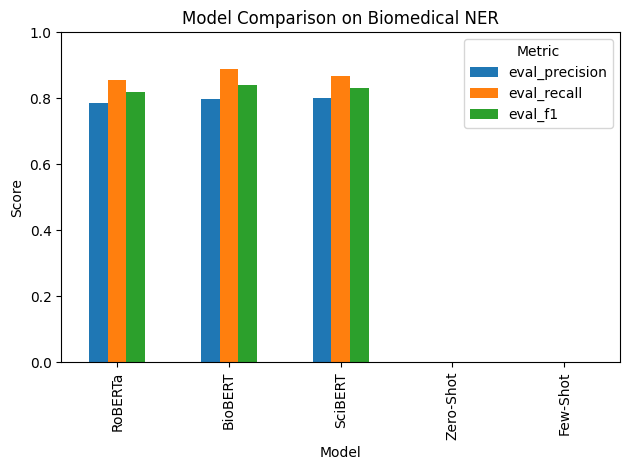

In [ ]:
# 2. Plot comparison graph
plt.figure(figsize=(10, 6))
results_df[['eval_precision', 'eval_recall', 'eval_f1']].plot(kind='bar')
plt.title('Model Comparison on Biomedical NER')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [ ]:
# 3. Error analysis function
def error_analysis(X_tokens, y_true, y_pred, idx2label, n_examples=5):
    print("\n--- ERROR ANALYSIS ---")
    shown = 0
    for i in range(len(y_true)):
        for j in range(len(y_true[i])):
            if y_true[i][j] != y_pred[i][j]:
                print(f"\nExample {i}, Token {j}:")
                print("Token      :", X_tokens[i][j])
                print("True Label :", idx2label[y_true[i][j]])
                print("Pred Label :", idx2label[y_pred[i][j]])
                shown += 1
                if shown >= n_examples:
                    return


<Figure size 1000x600 with 0 Axes>

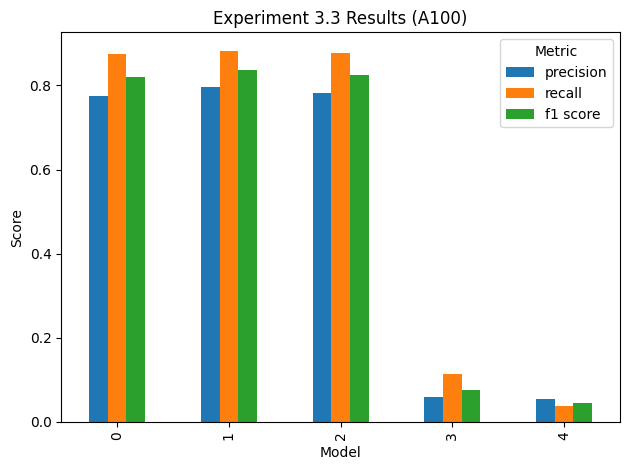

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
results_df[['precision', 'recall', 'f1 score']].plot(kind='bar')
plt.title('Experiment 3.3 Results (A100)')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

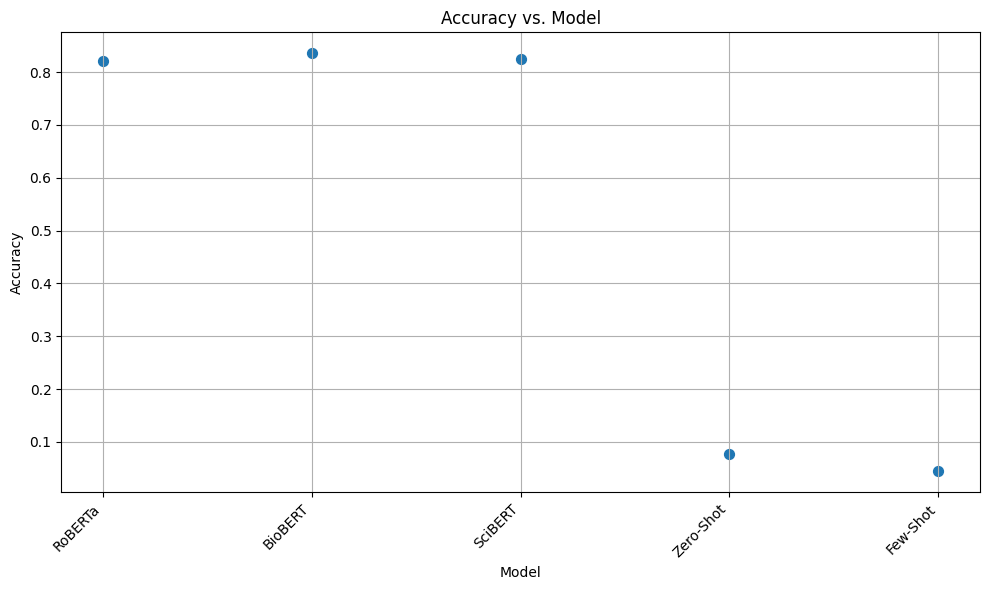

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
# Use results_d instead of results_df, and access the correct column.
plt.scatter(results_df['Model'], results_d['f1 score'], marker='o', s=50)
plt.xlabel("Model")
plt.ylabel("Accuracy") # If you want to label it "Accuracy" even if the actual data is f1 score
plt.title("Accuracy vs. Model")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()

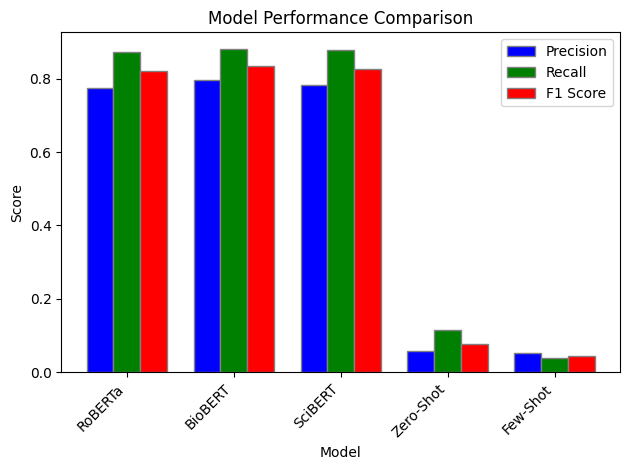

In [ ]:

# Assuming 'results_d' is your DataFrame with model names, precision, recall, and f1 score
models = results_df['Model']
precision = results_df['precision']
recall = results_df['recall']
f1_score = results_df['f1 score']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, edgecolor='grey', label='F1 Score')

# Add labels, title, and legend
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks([r + bar_width for r in range(len(models))], models, rotation=45, ha='right')
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()